In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,BatchNormalization
from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD,RMSprop
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

from keras.models import Sequential
warnings.filterwarnings('ignore')

from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dropout

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def display_images(desired_shape, images, num_images=6):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].reshape(desired_shape[0], desired_shape[1]), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_pixel_data(pixel_data, desired_shape):
    return np.array([np.array([float(x) for x in item.split()]).reshape(desired_shape) for item in pixel_data])

def process_labels(labels):
    # Convert labels to numerical format if they're not numeric
    unique_labels = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([unique_labels[label] for label in labels]), unique_labels

def make_model(pixel_data, labels):
    # Process pixel data
    input_shape = (256, 256, 1) # Corresponds to target_size in preprocess.py, but with an added dimension
    processed_images = process_pixel_data(pixel_data, desired_shape=input_shape)

    display_images(input_shape, processed_images)

    # Process labels
    processed_labels, label_map = process_labels(labels)
    processed_labels = to_categorical(processed_labels)

    # Splitting data into training and testing sets
    train_img, test_img, train_cancer_cat, test_cancer_cat = train_test_split(
        processed_images, processed_labels, test_size=0.2, random_state=42)
    
    # CNN Model
    model = Sequential([
        Conv2D(256, (3,3), activation='relu', padding='same', input_shape=input_shape),
        MaxPool2D(2,2),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPool2D(2,2),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPool2D(2,2),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(64, activation='relu'),
        Dense(len(label_map), activation='softmax') 
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_img, train_cancer_cat, epochs=3)

    # Evaluation
    print("Training accuracies:")
    print(history.history["accuracy"][-1])

    return model, label_map, history


In [33]:
import os
import subprocess
!find . -name ".DS_Store" -delete

# TODO: Need to make a for-loop that goes through every folder in images and annotations. This is 
# because the way the code works, it only goes through one folder at a time, so we need a loop
# that calls big_helper.py multiple times. I don't care about runtime anymore...

# NOTE: There will be Not-Found errors because not all the image files are downloaded even though all
# the annotations are downloaded.

# # Some of the stencil code uses depricated code, but it is still needed
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# This code block basically preprocesses the image data and puts it into a CSV file
for folder in os.listdir("dl_data/annotations"):
    dicom_path = f"dl_data/images/Lung_Dx-{folder}"
    annotation_path = f"dl_data/annotations/{folder}" 

    folder_list = ['A0001', 'A0002', 'A0003', 'A0004', 'A0005']
    
    if folder not in folder_list:
        continue
    else:
        print(folder)
    
    command = [
        "python", "preprocess.py", "--dicom-mode", "CT",
        "--dicom-path", dicom_path,
        "--annotation-path", annotation_path,
        "--classfile", "category.txt"
    ]
    
    # Execute the command
    subprocess.run(command)

A0001
Folder/File Found
A0003
Folder/File Found
A0004
Folder/File Found
Possible key error
Possible key error
Possible key error
Possible key error
Possible key error
A0005
Folder/File Found
Possible key error
Possible key error
A0002
Folder/File Found


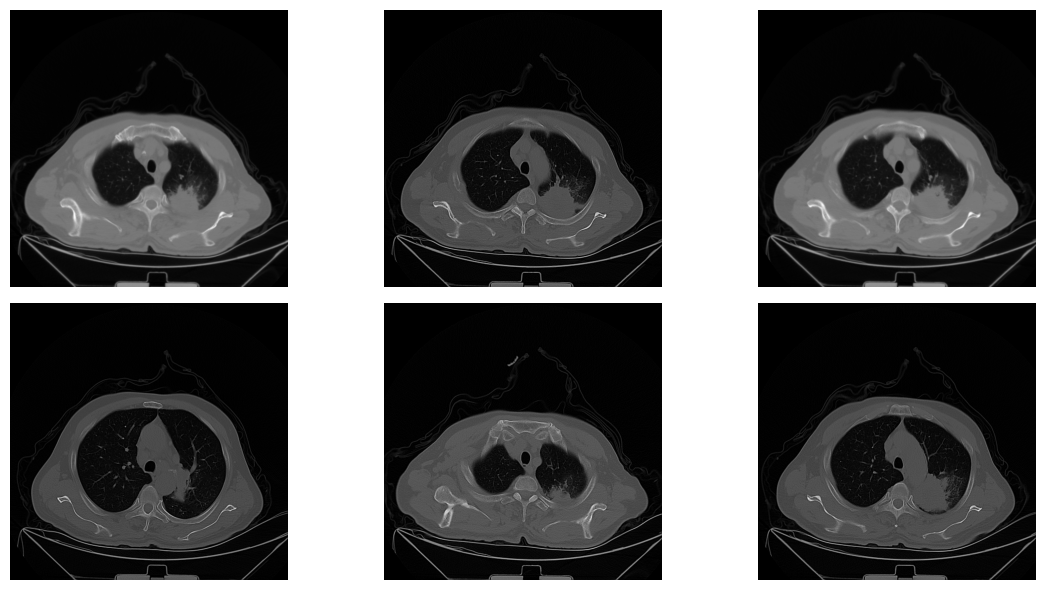

Epoch 1/3


In [36]:
data = pd.read_csv('output.csv')
model, label_map, history = make_model(data['pixel_data'], data['cancer_type'])